# **CAPSTONE**
Checklist of Basic Steps for FMD Project


1.   Load and Inspect Dataset Preprocessing (Cleaning, Tokenization, Lemmatization, Stopword Removal)✅
2.  Feature Engineering (TF-IDF for traditional ML, Embeddings for RNNs)✅
3.  Train-Test Split, Model Selection (Logistic Regression, RNN with LSTM), Training and Evaluation (Accuracy, Classification Report)✅
4.  Implement Transformer (BERT) Model✅
5.  Comparision of three Models✅



# Step 1: Preprocessing the Data

1.1 load the dataset

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
import pandas as pd

# Load dataset
file_path = "/content/drive/MyDrive/train.json"
df = pd.read_json(file_path, lines=True)

# Display first few rows
print(df.head())


            ID                                              claim      posted  \
0  FMD_train_0                        Amazon.com and Intifada.com  09/25/2001   
1  FMD_train_1                          $100 JCPenney Coupon Scam  08/10/2015   
2  FMD_train_2  Did Ford Make Colin Kaepernick the Face of The...  09/10/2018   
3  FMD_train_3  State Dept. Employee Candace Claiborne Arreste...  04/15/2017   
4  FMD_train_4  No, Sean Connery's family did not become emoti...  12/03/2020   

                                          sci_digest  \
0  [Is the web site Intifada.com partnered with A...   
1                                                 []   
2  [A joke posted to the political humor section ...   
3  [Department of State employee Candace Claiborn...   
4  [We recently saw the same misleading advertisi...   

                                       justification      issues  \
0  Claim:  On-line bookseller Amazon.com is partn...    [profit]   
1  FACT CHECK: Can Facebook users get a 

1.2 Handle Missing Values

In [5]:
# Check for missing values
print(df.isnull().sum())

# Drop rows with missing values (if any)
df = df.dropna()


ID               0
claim            0
posted           0
sci_digest       0
justification    0
issues           0
image_data       0
label            0
evidence         0
dtype: int64


1.3 Normalize text

In [6]:
import re
import nltk
from nltk.corpus import stopwords

nltk.download("stopwords")
stop_words = set(stopwords.words("english"))

def clean_text(text):
    text = text.lower()  # Convert to lowercase
    text = re.sub(r'\W', ' ', text)  # Remove special characters
    text = re.sub(r'\s+', ' ', text).strip()  # Remove extra spaces
    text = " ".join([word for word in text.split() if word not in stop_words])  # Remove stopwords
    return text

df["clean_claim"] = df["claim"].apply(clean_text)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


1.4 tokenization and Lemmatization

In [7]:
from nltk.stem import WordNetLemmatizer

nltk.download("wordnet")
lemmatizer = WordNetLemmatizer()

def tokenize_lemmatize(text):
    tokens = text.split()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    return " ".join(tokens)

df["clean_claim"] = df["clean_claim"].apply(tokenize_lemmatize)


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [8]:
print(df["label"].value_counts())


label
False    892
True     717
NEI      344
Name: count, dtype: int64


1.5 Convert Labels into Numerical Format

In [9]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
df["label_encoded"] = label_encoder.fit_transform(df["label"])  # Converts labels to numbers

# Show label mappings
print(dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_))))


{'False': np.int64(0), 'NEI': np.int64(1), 'True': np.int64(2)}


# Step 2: Feature Engineering

2.1 Convert Text into Numerical Features

In [10]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Initialize TF-IDF Vectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=5000)  # Limit to top 5000 words

# Fit and transform the claims
X = tfidf_vectorizer.fit_transform(df["clean_claim"])

# Convert to dense array
X = X.toarray()

# Show shape of transformed data
print("TF-IDF Feature Matrix Shape:", X.shape)


TF-IDF Feature Matrix Shape: (1953, 4659)


2.2 Split the Dataset into Training & Testing Sets

In [11]:
from sklearn.model_selection import train_test_split

# Target labels
y = df["label_encoded"]

# Split into training and testing sets (80-20 split)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Print dataset sizes
print("Training Set Size:", X_train.shape)
print("Testing Set Size:", X_test.shape)


Training Set Size: (1562, 4659)
Testing Set Size: (391, 4659)


# Step 3: Model Selection and trainning

3.1 Train a Logistic Regression Model

In [12]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

# Initialize and train the model
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print("Logistic Regression Accuracy:", accuracy)
print("\nClassification Report:\n", classification_report(y_test, y_pred))


Logistic Regression Accuracy: 0.649616368286445

Classification Report:
               precision    recall  f1-score   support

           0       0.60      0.92      0.73       177
           1       1.00      0.06      0.11        68
           2       0.74      0.60      0.66       146

    accuracy                           0.65       391
   macro avg       0.78      0.53      0.50       391
weighted avg       0.72      0.65      0.60       391



3.2 Experiment with Other Models (RNN)

3.2.1 Convert Text into Sequences

In [13]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Hyperparameters
max_words = 5000  # Max number of words in vocabulary
max_len = 100  # Max length of input sequence

# Tokenize the text
tokenizer = Tokenizer(num_words=max_words, oov_token="<OOV>")
tokenizer.fit_on_texts(df["clean_claim"])

# Convert text to sequences
X_sequences = tokenizer.texts_to_sequences(df["clean_claim"])

# Pad sequences to ensure equal length
X_padded = pad_sequences(X_sequences, maxlen=max_len, padding="post")

# Convert labels to numpy array
y = df["label_encoded"].values

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_padded, y, test_size=0.2, random_state=42)

print("Training data shape:", X_train.shape)
print("Testing data shape:", X_test.shape)


Training data shape: (1562, 100)
Testing data shape: (391, 100)


3.2.2 Define an RNN Model with LSTM

In [14]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout

# Define the RNN model
model = Sequential([
    Embedding(input_dim=max_words, output_dim=128, input_length=max_len),
    LSTM(64, return_sequences=True),
    LSTM(32),
    Dropout(0.5),
    Dense(32, activation="relu"),
    Dense(3, activation="softmax")  # 3 output classes (True, False, NEI)
])

# Compile the model
model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

# Print model summary
model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

3.2.3 Train the Model

In [15]:
# Train the model
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))


Epoch 1/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 14s 130ms/step - accuracy: 0.4336 - loss: 1.0648 - val_accuracy: 0.4527 - val_loss: 1.0383
Epoch 2/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 10s 135ms/step - accuracy: 0.4371 - loss: 1.0307 - val_accuracy: 0.4527 - val_loss: 1.0331
Epoch 3/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 6s 118ms/step - accuracy: 0.4451 - loss: 1.0381 - val_accuracy: 0.4527 - val_loss: 1.0379
Epoch 4/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 11s 141ms/step - accuracy: 0.4369 - loss: 1.0489 - val_accuracy: 0.4527 - val_loss: 1.0310
Epoch 5/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 9s 123ms/step - accuracy: 0.4762 - loss: 1.0275 - val_accuracy: 0.4527 - val_loss: 1.0417
Epoch 6/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 6s 124ms/step - accuracy: 0.4279 - loss: 1.0510 - val_accuracy: 0.4527 - val_loss: 1.0312
Epoch 7/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 10s 114ms/step - accuracy: 0.4671 - loss: 1.0332 - val_accuracy: 0.4527 - val_loss: 1.0309
Epoch 8/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 7s 149ms/step - accuracy: 0.4503 - loss: 1.0283 - val_accuracy

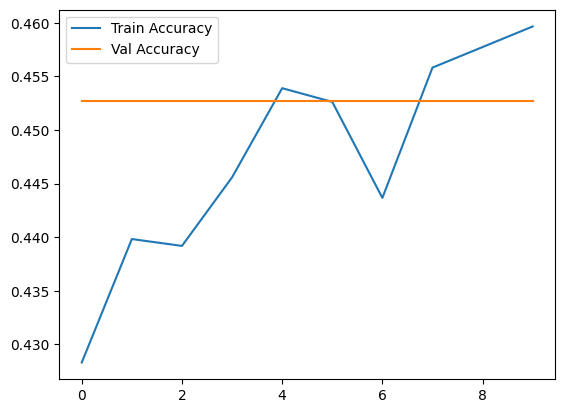

In [16]:
import matplotlib.pyplot as plt

plt.plot(history.history["accuracy"], label="Train Accuracy")
plt.plot(history.history["val_accuracy"], label="Val Accuracy")
plt.legend()
plt.show()


3.2.4  Evaluate the Model

In [17]:
# Evaluate on test data
test_loss, test_acc = model.evaluate(X_test, y_test)
print("Test Accuracy:", test_acc)

# Make predictions
y_pred = model.predict(X_test)
y_pred_classes = y_pred.argmax(axis=1)

# Classification report
from sklearn.metrics import classification_report
print("\nClassification Report:\n", classification_report(y_test, y_pred_classes))


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.4235 - loss: 1.0596
Test Accuracy: 0.4526854157447815
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step

Classification Report:
               precision    recall  f1-score   support

           0       0.45      1.00      0.62       177
           1       0.00      0.00      0.00        68
           2       0.00      0.00      0.00       146

    accuracy                           0.45       391
   macro avg       0.15      0.33      0.21       391
weighted avg       0.20      0.45      0.28       391



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


# Step 4: Steps to Implement Transformer (BERT) Model

1. Install & Import Dependencies

In [18]:
# Loading Libraries
import tensorflow as tf
from transformers import BertTokenizer, TFBertForSequenceClassification
from tensorflow.keras.optimizers.schedules import PolynomialDecay
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
import numpy as np

2. Load a Pretrained & Tokenize your Data

In [19]:
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [20]:
# Step 2: Tokenize Dataset
def tokenize_texts(texts, max_length=100):
    return tokenizer(
        texts.tolist(), padding=True, truncation=True, max_length=max_length, return_tensors="tf"
    )

X_tokenized = tokenize_texts(df["clean_claim"])
y = df["label_encoded"].values


In [21]:
# Step 3: Train-Test Split
X_input_ids = np.array(X_tokenized["input_ids"])  # Convert Tensor to NumPy array
y = np.array(y)  # Ensure labels are also a NumPy array

X_train, X_test, y_train, y_test = train_test_split(
    X_input_ids, y, test_size=0.2, random_state=42, stratify=y
)


3.Fine-Tune BERT on dataset

In [22]:
# Step 4: Convert to TensorFlow Datasets
dataset_train = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(16)
dataset_test = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(16)


4. Train and Evaluate

In [38]:
# Step 5: Load Pretrained BERT Model
model = TFBertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=3)

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [41]:
# Checking version of tensorflow
import tensorflow as tf
print(tf.__version__)


2.19.0


In [40]:
# Model summary
print(model.summary())


Model: "tf_bert_for_sequence_classification_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  109482240 
                                                                 
 dropout_227 (Dropout)       multiple                  0 (unused)
                                                                 
 classifier (Dense)          multiple                  2307      
                                                                 
Total params: 109484547 (417.65 MB)
Trainable params: 109484547 (417.65 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


In [42]:
#checking the dataset
print(dataset_train)


<_BatchDataset element_spec=(TensorSpec(shape=(None, 43), dtype=tf.int32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>


In [27]:
dataset_train = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(16)
dataset_test = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(16)


# Combining and training BERT Model

In [28]:
import tensorflow as tf
from transformers import BertTokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard
from tensorflow.keras import regularizers
from sklearn.model_selection import train_test_split
import numpy as np

# Step 1: Load BERT Tokenizer
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

# Step 2: Tokenize Dataset
def tokenize_texts(texts, max_length=100):
    tokenized = tokenizer(
        texts.tolist(),
        padding="max_length",
        truncation=True,
        max_length=max_length,
        return_tensors="tf"
    )
    return tokenized["input_ids"], tokenized["attention_mask"]

X_input_ids, X_attention_mask = tokenize_texts(df["clean_claim"])
y = tf.convert_to_tensor(df["label_encoded"].values, dtype=tf.int32)

# Step 3: Train-Test Split
X_train_ids, X_test_ids, y_train, y_test = train_test_split(
    X_input_ids.numpy(),
    y.numpy(),
    test_size=0.2,
    random_state=42,
    stratify=y.numpy()
)

# Step 4: Create Keras Sequential Model - CORRECTED
model = Sequential([
    Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.01), input_shape=(100,)),
    Dropout(0.5),
    Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    Dropout(0.5),
    Dense(3, activation='softmax')
])

# Step 5: Compile Model
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Step 6: Callbacks
callbacks = [
    ModelCheckpoint('best_model.h5', monitor='val_accuracy', save_best_only=True),
    TensorBoard(log_dir='./logs')
]

# Step 7: Train Model
history = model.fit(
    X_train_ids,
    y_train,
    validation_data=(X_test_ids, y_test),
    epochs=10,
    batch_size=32,
    callbacks=callbacks
)

# Step 8-9: Evaluation and Prediction (same as before)
test_loss, test_acc = model.evaluate(X_test_ids, y_test)
print(f"Test Accuracy: {test_acc:.4f}")

y_pred = model.predict(X_test_ids)
y_pred_classes = np.argmax(y_pred, axis=1)

from sklearn.metrics import classification_report
print("\nClassification Report:\n", classification_report(y_test, y_pred_classes))

Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


47/49 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3771 - loss: 1902.9816

49/49 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.3779 - loss: 1881.1903 - val_accuracy: 0.4731 - val_loss: 263.4154
Epoch 2/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.3932 - loss: 866.9243 - val_accuracy: 0.4118 - val_loss: 120.3406
Epoch 3/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.3907 - loss: 460.2104 - val_accuracy: 0.4194 - val_loss: 55.5287
Epoch 4/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.4241 - loss: 267.2705 - val_accuracy: 0.4348 - val_loss: 19.7399
Epoch 5/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4034 - loss: 139.9650 - val_accuracy: 0.4399 - val_loss: 4.6047
Epoch 6/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.4005 - loss: 67.2412 - val_accuracy: 0.3146 - val_loss: 2.9037
Epoch 7/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.3865 - loss: 45.5284 - val_accuracy: 0.3811 - val_loss: 2.3581
Epoch 8/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4021 - loss: 26.0135 - val_accuracy: 0.4297 -

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


# 5. Comparision of Accuracy, Precision and recall of three models (LR, RNN, BERT)


Printing LR, RNN Values

In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
import tensorflow as tf
from transformers import BertTokenizer, TFBertForSequenceClassification

# Load and preprocess data
df = pd.read_json("/content/drive/MyDrive/train.json", lines=True)
df = df.dropna()

# Text cleaning function
def clean_text(text):
    text = text.lower()
    text = re.sub(r'\\W', ' ', text)
    text = re.sub(r'\\s+', ' ', text).strip()
    return text

df["clean_claim"] = df["claim"].apply(clean_text)

# Encode labels
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
df["label_encoded"] = label_encoder.fit_transform(df["label"])

# Common train-test split
X_train, X_test, y_train, y_test = train_test_split(
    df["clean_claim"], df["label_encoded"],
    test_size=0.2, random_state=42, stratify=df["label_encoded"]
)

# 1. Logistic Regression Model
print("\n" + "="*50)
print("LOGISTIC REGRESSION MODEL")
print("="*50)

tfidf = TfidfVectorizer(max_features=5000)
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

lr_model = LogisticRegression(max_iter=1000)
lr_model.fit(X_train_tfidf, y_train)
lr_pred = lr_model.predict(X_test_tfidf)

print(classification_report(y_test, lr_pred))
lr_accuracy = accuracy_score(y_test, lr_pred)

# 2. RNN Model
print("\n" + "="*50)
print("RNN MODEL")
print("="*50)

tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

X_train_pad = tf.keras.preprocessing.sequence.pad_sequences(X_train_seq, maxlen=100)
X_test_pad = tf.keras.preprocessing.sequence.pad_sequences(X_test_seq, maxlen=100)

rnn_model = tf.keras.Sequential([
    tf.keras.layers.Embedding(5000, 128, input_length=100),
    tf.keras.layers.LSTM(64, return_sequences=True),
    tf.keras.layers.LSTM(32),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(3, activation='softmax')
])

rnn_model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
rnn_model.fit(X_train_pad, y_train, epochs=10, batch_size=32, validation_data=(X_test_pad, y_test))

rnn_pred = rnn_model.predict(X_test_pad)
rnn_pred_classes = np.argmax(rnn_pred, axis=1)

print(classification_report(y_test, rnn_pred_classes))
rnn_accuracy = accuracy_score(y_test, rnn_pred_classes)


LOGISTIC REGRESSION MODEL
              precision    recall  f1-score   support

           0       0.61      0.85      0.71       179
           1       0.65      0.16      0.26        69
           2       0.74      0.64      0.68       143

    accuracy                           0.65       391
   macro avg       0.66      0.55      0.55       391
weighted avg       0.66      0.65      0.62       391


RNN MODEL


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 22s 272ms/step - accuracy: 0.4464 - loss: 1.0758 - val_accuracy: 0.5601 - val_loss: 1.0048
Epoch 2/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 12s 236ms/step - accuracy: 0.6120 - loss: 0.9621 - val_accuracy: 0.6164 - val_loss: 0.8659
Epoch 3/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 15s 131ms/step - accuracy: 0.6989 - loss: 0.7118 - val_accuracy: 0.6343 - val_loss: 0.8732
Epoch 4/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 11s 149ms/step - accuracy: 0.7865 - loss: 0.4469 - val_accuracy: 0.5831 - val_loss: 1.0235
Epoch 5/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 9s 117ms/step - accuracy: 0.8919 - loss: 0.2808 - val_accuracy: 0.5090 - val_loss: 1.3049
Epoch 6/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 10s 112ms/step - accuracy: 0.9227 - loss: 0.1894 - val_accuracy: 0.5652 - val_loss: 1.5951
Epoch 7/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 8s 156ms/step - accuracy: 0.9664 - loss: 0.1210 - val_accuracy: 0.5371 - val_loss: 1.9451
Epoch 8/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 6s 114ms/step - accuracy: 0.9740 - loss: 0.0831 - val_accurac

Comparision of Three Models

In [36]:
import pandas as pd
from sklearn.metrics import accuracy_score, classification_report

# Collect accuracy values
model_accuracies = {
    "Logistic Regression": lr_accuracy,
    "RNN": rnn_accuracy,
    "BERT (MLP)": test_acc
}

# Print accuracy comparison
print("\n" + "="*50)
print("MODEL ACCURACY COMPARISON")
print("="*50)
for model, acc in model_accuracies.items():
    print(f"{model}: {acc:.4f}")

# Extract precision and recall from classification reports
lr_report = classification_report(y_test, lr_pred, output_dict=True)
rnn_report = classification_report(y_test, rnn_pred_classes, output_dict=True)
bert_report = classification_report(y_test, y_pred_classes, output_dict=True)

precision_values = {
    "Logistic Regression": lr_report["weighted avg"]["precision"],
    "RNN": rnn_report["weighted avg"]["precision"],
    "BERT (MLP)": bert_report["weighted avg"]["precision"]
}

recall_values = {
    "Logistic Regression": lr_report["weighted avg"]["recall"],
    "RNN": rnn_report["weighted avg"]["recall"],
    "BERT (MLP)": bert_report["weighted avg"]["recall"]
}

# Print precision comparison
print("\n" + "="*50)
print("MODEL PRECISION COMPARISON")
print("="*50)
for model, prec in precision_values.items():
    print(f"{model}: {prec:.4f}")

# Print recall comparison
print("\n" + "="*50)
print("MODEL RECALL COMPARISON")
print("="*50)
for model, rec in recall_values.items():
    print(f"{model}: {rec:.4f}")



MODEL ACCURACY COMPARISON
Logistic Regression: 0.6496
RNN: 0.5985
BERT (MLP): 0.4373

MODEL PRECISION COMPARISON
Logistic Regression: 0.6620
RNN: 0.6434
BERT (MLP): 0.2435

MODEL RECALL COMPARISON
Logistic Regression: 0.6496
RNN: 0.5985
BERT (MLP): 0.4373


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


#Graph Comparision

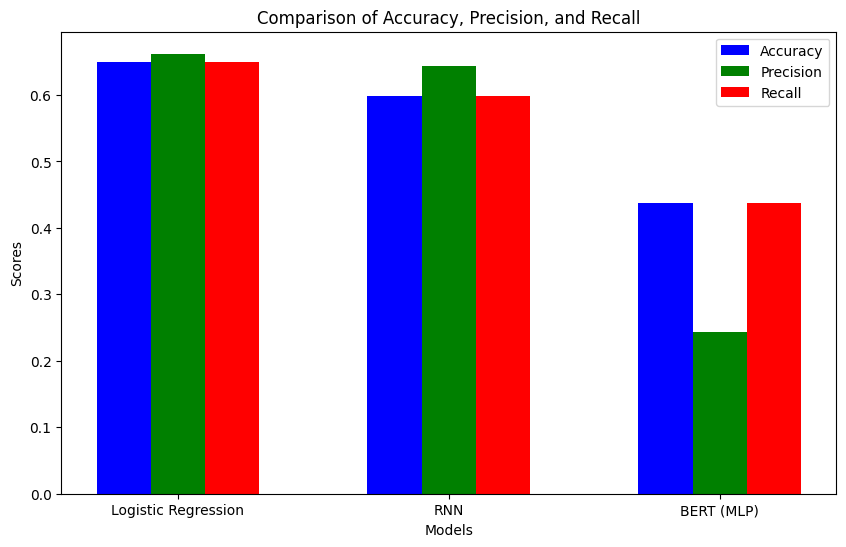

In [37]:
import matplotlib.pyplot as plt
import numpy as np

# Model names
models = ["Logistic Regression", "RNN", "BERT (MLP)"]

# Accuracy values
accuracy_values = [lr_accuracy, rnn_accuracy, test_acc]

# Precision values
precision_values = [lr_report["weighted avg"]["precision"],
                    rnn_report["weighted avg"]["precision"],
                    bert_report["weighted avg"]["precision"]]

# Recall values
recall_values = [lr_report["weighted avg"]["recall"],
                 rnn_report["weighted avg"]["recall"],
                 bert_report["weighted avg"]["recall"]]

# Set bar width
bar_width = 0.2
x = np.arange(len(models))

# Create bar chart
plt.figure(figsize=(10, 6))

plt.bar(x - bar_width, accuracy_values, width=bar_width, label="Accuracy", color="blue")
plt.bar(x, precision_values, width=bar_width, label="Precision", color="green")
plt.bar(x + bar_width, recall_values, width=bar_width, label="Recall", color="red")

# Add labels and title
plt.xlabel("Models")
plt.ylabel("Scores")
plt.title("Comparison of Accuracy, Precision, and Recall")
plt.xticks(ticks=x, labels=models)
plt.legend()

# Show plot
plt.show()
